**Import** **Dependencies**

In [127]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
os.path.join('data','happy')

'data/happy'

In [4]:
gpus=tf.config.experimental.list_physical_devices('GPU')
len(gpus)

0

**Remove** **Undesired** **Images**

In [5]:
import cv2
import imghdr #To check the file extention

In [6]:
data_dir='/content/drive/MyDrive/mood_dataset/data'

In [20]:
images=os.listdir(os.path.join(data_dir,'sad'))

In [11]:
len(images)

100

**Remove unwanted file extentions and small sized images**

In [9]:
image_exts=['jpeg','jpg','bmp','png']

In [10]:
from logging import exception
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class,image)
    try:
      img=cv2.imread(image_path)
      ext=imghdr.what(image_path)
      size= os.path.getsize(image_path)/1024
      if ext not in image_exts:
        print(f"Image not in ext list {image_path}")
        os.remove(image_path)
      elif size<= 9:
        print(f"Image is too small {image_path}")
        os.remove(image_path)
    except exception as e:
      print(f"Issue with an image {image_path}")


**Load** **Data**

In [12]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 177 files belonging to 2 classes.


In [13]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [31]:
data_iterator = data.as_numpy_iterator()

In [39]:
#get another batch from the iterator
batch = data_iterator.next()

In [40]:
#images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [41]:
batch[1]

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

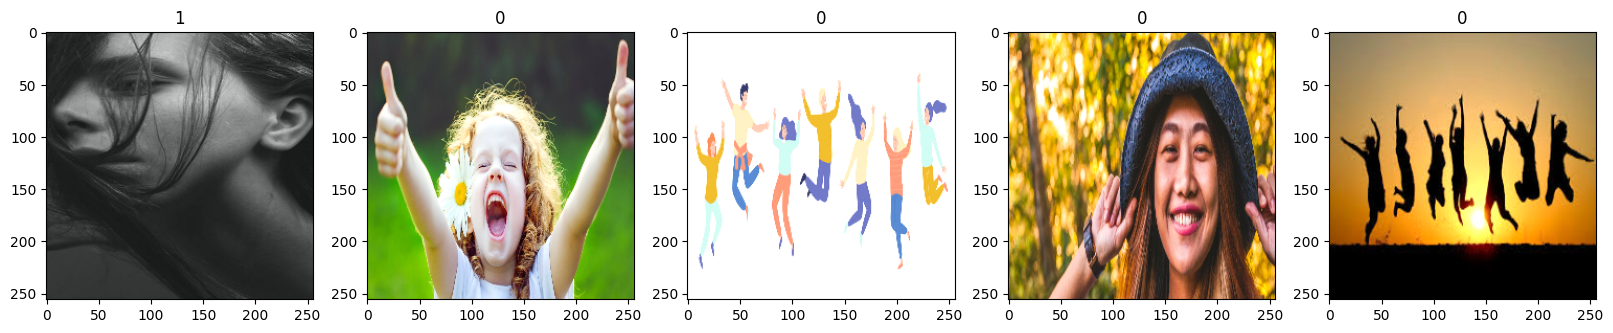

In [42]:
fig,ax = plt.subplots(ncols=5,figsize=(20,20))
for idx,image in enumerate(batch[0][:5]):
   ax[idx].imshow(image)
   ax[idx].title.set_text(batch[1][idx])

**Scale Data**

In [43]:
data = data.map(lambda x,y:(x/225,y))

In [44]:
data.as_numpy_iterator().next()

(array([[[[8.09876539e-04, 1.24444440e-03, 2.21234583e-03],
          [8.29629658e-04, 1.26419752e-03, 2.23209895e-03],
          [8.29629658e-04, 1.26419752e-03, 2.23209895e-03],
          ...,
          [2.23333342e-03, 2.68765423e-03, 3.49753094e-03],
          [2.23333342e-03, 2.68765423e-03, 3.49753094e-03],
          [2.23333342e-03, 2.70740758e-03, 3.45802470e-03]],
 
         [[8.09876539e-04, 1.24444440e-03, 2.21234583e-03],
          [8.29629658e-04, 1.26419752e-03, 2.23209895e-03],
          [8.29629658e-04, 1.26419752e-03, 2.23209895e-03],
          ...,
          [2.25555548e-03, 2.70987651e-03, 3.51975299e-03],
          [2.25555548e-03, 2.70987651e-03, 3.51975299e-03],
          [2.25555548e-03, 2.72962963e-03, 3.48024676e-03]],
 
         [[8.16049404e-04, 1.25061721e-03, 2.21851841e-03],
          [8.35802464e-04, 1.27037033e-03, 2.23827153e-03],
          [8.35802464e-04, 1.27037033e-03, 2.23827153e-03],
          ...,
          [2.27777776e-03, 2.73209880e-03, 3.5419

In [45]:
len(data)

6

**Split Data**

In [55]:
train_size=int(len(data)*.7)
val_size=int(len(data)*.2)
test_size=int(len(data)*.1)+1

In [58]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


In [128]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [129]:
datagen.fit(train)

TypeError: float() argument must be a string or a real number, not '_TakeDataset'

**Deep Learning**

**Build deep learning model**

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

In [120]:
model = Sequential()

In [121]:
#layer1
model.add(Conv2D(16, (3,3), 1, activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

#layer2
model.add(Conv2D(32, (3,3), 1,activation='relu'))
model.add(MaxPooling2D())

#layer3
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
# Dropout(0.5)

#layer4
model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
# Dropout(0.6)

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [122]:

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [123]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 30, 30, 64)       

In [124]:
logdir='/content/drive/MyDrive/mood_dataset/logs'

In [125]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [126]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 19s 4s/step - loss: 0.6931 - accuracy: 0.6016 - val_loss: 0.6931 - val_accuracy: 0.5625
Epoch 2/20
4/4 [==============================] - 17s 4s/step - loss: 0.6930 - accuracy: 0.5391 - val_loss: 0.6932 - val_accuracy: 0.4688
Epoch 3/20
4/4 [==============================] - 17s 3s/step - loss: 0.6928 - accuracy: 0.5859 - val_loss: 0.6929 - val_accuracy: 0.5312
Epoch 4/20
4/4 [==============================] - 17s 3s/step - loss: 0.6928 - accuracy: 0.5469 - val_loss: 0.6925 - val_accuracy: 0.5938
Epoch 5/20
4/4 [==============================] - 18s 4s/step - loss: 0.6926 - accuracy: 0.5781 - val_loss: 0.6916 - val_accuracy: 0.6875
Epoch 6/20
4/4 [==============================] - 17s 4s/step - loss: 0.6923 - accuracy: 0.5703 - val_loss: 0.6933 - val_accuracy: 0.4375
Epoch 7/20
4/4 [==============================] - 17s 4s/step - loss: 0.6919 - accuracy: 0.5938 - val_loss: 0.6931 - val_accuracy: 0.4688
Epoch 8/20
4/4 [==================

**plot performance**

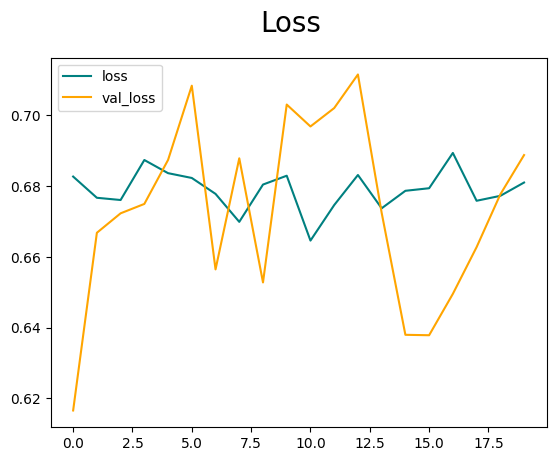

In [117]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

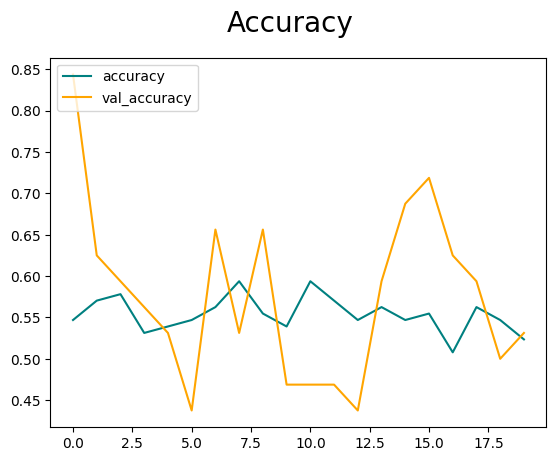

In [119]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()